# day 202 and day 204

# goal 1:

Make a binary classification dataset with Scikit-Learn's make_moons() function.
For consistency, the dataset should have 1000 samples and a random_state=42.
Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 6.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import requests
import zipfile
import os
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
import torchmetrics
import pathlib

ModuleNotFoundError: ignored

In [ ]:
# getting the datasets
x,y = make_moons(n_samples=1000,
                 noise=0.03,
                 random_state=42)

# train_test_splitting
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

# converting the dtypes to tensor
def tensor_convert(x):
  return torch.tensor(x,dtype=torch.float32)
x_train,x_test,y_train, y_test = map(tensor_convert,(x_train,x_test,y_train,y_test))


# making the data device agnostic:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def device_agnostic(x):
  return x.to(device)

x_train,x_test,y_train,y_test = map(device_agnostic,(x_train,x_test,y_train,y_test))



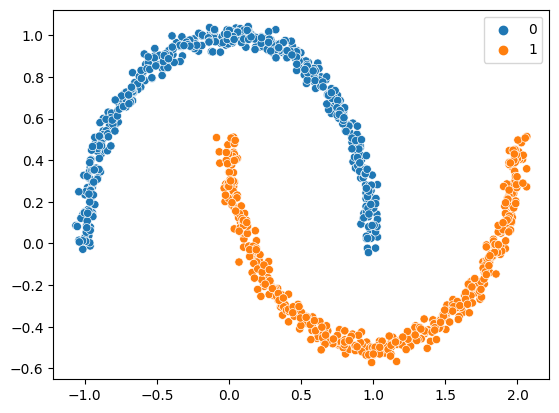

In [ ]:
sns.scatterplot(x=x[:,0],y=x[:,1],hue=y);

# goal2:

Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [ ]:
class ClassificationModelV0(torch.nn.Module):
  def __init__(self,i,o,h):
    super().__init__()

    self.neural_layers_stack = torch.nn.Sequential(
        torch.nn.Linear(in_features=i,out_features=h),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=h,out_features=h),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=h,out_features=h),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=h,out_features=h),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=h,out_features=o)
    )

  def forward(self,x:torch.Tensor):
    return self.neural_layers_stack(x)

# creating the model0
model0 = ClassificationModelV0(i=2,o=1,h=5)


model0 = model0.to(device)

# goal3:

Setup a binary classification compatible loss function and optimizer to use when training the model.


In [ ]:
# compiling the model
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model0.parameters(),
                            lr=0.01)
accuracy = torchmetrics.Accuracy(task='binary',num_classes=2)



# goal4:

Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
To measure model accuray, you can create your own accuracy function or use the accuracy function in TorchMetrics.
Train the model for long enough for it to reach over 96% accuracy.
The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [ ]:
# fitting the model

# setting random seeds:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

for epoch in range(epochs):
  # training
  model0.train()

  # getting train_loss and train_accuracy
  train_logits = model0(x_train).squeeze()
  train_prediction = torch.round(torch.sigmoid(train_logits))
  train_actual = y_train
  train_loss = loss(train_logits,train_actual)
  train_accuracy = accuracy(train_prediction,train_actual)

  # zeroing the gradients in optimizer in every new epoch
  optimizer.zero_grad()

  # backpropogating the training loss
  train_loss.backward()

  # stepping the optimizer up a notch
  optimizer.step()

  # testing
  model0.eval()

  with torch.inference_mode():
    test_logits = model0(x_test).squeeze()
    test_prediction = torch.round(torch.sigmoid(test_logits))
    test_actual = y_test
    test_loss = loss(test_logits,test_actual)
    test_accuracy = accuracy(test_prediction,test_actual)

    # printing the results
    if epoch%10 == 0:
      print('Epoch: {} | Train_Loss: {:.4f} , Train_Accuracy: {:.4f} | Test_Loss: {:.4f} , Test_Accuracy: {:.4f}'\
          .format(epoch,train_loss,train_accuracy,test_loss,test_accuracy))




Epoch: 0 | Train_Loss: 0.7460 , Train_Accuracy: 0.5000 | Test_Loss: 0.7385 , Test_Accuracy: 0.5000
Epoch: 10 | Train_Loss: 0.7008 , Train_Accuracy: 0.5000 | Test_Loss: 0.6996 , Test_Accuracy: 0.5000
Epoch: 20 | Train_Loss: 0.6733 , Train_Accuracy: 0.5000 | Test_Loss: 0.6712 , Test_Accuracy: 0.5000
Epoch: 30 | Train_Loss: 0.6087 , Train_Accuracy: 0.5000 | Test_Loss: 0.6085 , Test_Accuracy: 0.5000
Epoch: 40 | Train_Loss: 0.5134 , Train_Accuracy: 0.5000 | Test_Loss: 0.5141 , Test_Accuracy: 0.7900
Epoch: 50 | Train_Loss: 0.4380 , Train_Accuracy: 0.9087 | Test_Loss: 0.4291 , Test_Accuracy: 0.9050
Epoch: 60 | Train_Loss: 0.3813 , Train_Accuracy: 0.9225 | Test_Loss: 0.3617 , Test_Accuracy: 0.9200
Epoch: 70 | Train_Loss: 0.3355 , Train_Accuracy: 0.9312 | Test_Loss: 0.3170 , Test_Accuracy: 0.9350
Epoch: 80 | Train_Loss: 0.2876 , Train_Accuracy: 0.9675 | Test_Loss: 0.2709 , Test_Accuracy: 0.9850
Epoch: 90 | Train_Loss: 0.2372 , Train_Accuracy: 0.9937 | Test_Loss: 0.2310 , Test_Accuracy: 0.9950


# goal 5:
Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

In [ ]:
if pathlib.Path('helper_functions.py').is_file():
  print('Already Downloaded')

else:
  print('Downloading the helper functions')
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py').content
  with open('helper_functions','wb') as f:
    f.write(request)




In [ ]:
from helper_functions import plot_decision_boundary

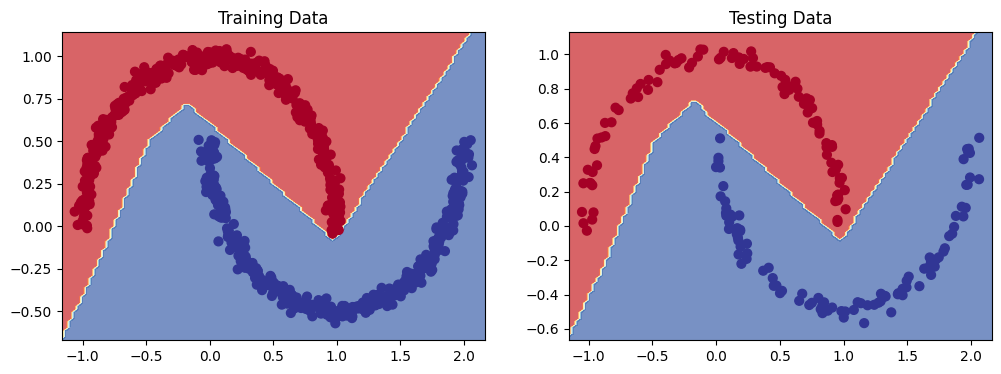

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Training Data')
plot_decision_boundary(model0,x_train,y_train)


plt.subplot(1,2,2)
plt.title('Testing Data')
plot_decision_boundary(model0,x_test,y_test)


plt.show()

# goal 6:

Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
Feel free to reference the ML cheatsheet website for the formula.

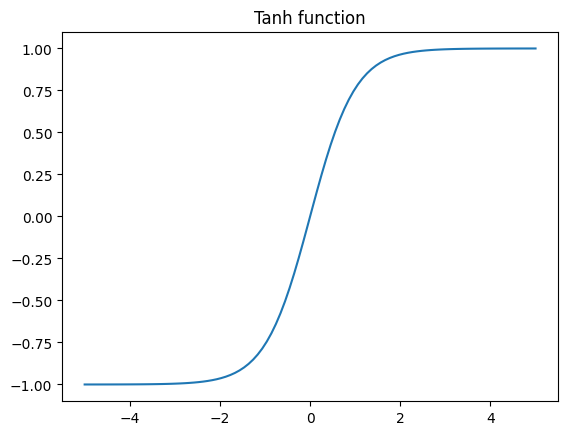

In [ ]:
# pure pytorch tanh function
x = torch.linspace(-5,5,100)

tanh = (torch.exp(x) - torch.exp(-x))/(torch.exp(x) + torch.exp(-x))

# plotting
plt.plot(x,tanh)
plt.title('Tanh function')
plt.show()

In [ ]:
# instatiating the model with tanh activation
class ClassificationModelV1(torch.nn.Module):
  def __init__(self,i,o,h):
    super().__init__()

    self.neural_layers_stack = torch.nn.Sequential(
        torch.nn.Linear(in_features=i,out_features=h),
        torch.nn.Tanh(),
        torch.nn.Linear(in_features=h,out_features=h),
        torch.nn.Tanh(),
        torch.nn.Linear(in_features=h,out_features=h),
        torch.nn.Tanh(),
        torch.nn.Linear(in_features=h,out_features=h),
        torch.nn.Tanh(),
        torch.nn.Linear(in_features=h,out_features=o)
    )

  def forward(self,x):
    return self.neural_layers_stack(x)


# creating the model1
model1 = ClassificationModelV1(i=2,o=1,h=5)


# compiling the model
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model1.parameters(),
                           lr=0.1)
accuracy = torchmetrics.Accuracy(task='binary',num_classes=2)

# fitting the model
torch.random.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

for epoch in range(epochs):
  # training
  model1.train()

  # getting train loss and train accuracy
  train_logits = model1(x_train).squeeze()
  train_prediction = torch.round(torch.sigmoid(train_logits))
  train_actual = y_train
  train_loss = loss(train_logits,train_actual)
  train_accuracy = accuracy(train_prediction,train_actual)

  # setting the optimizer to zero grad on every epoch
  optimizer.zero_grad()

  # back propogate the losses
  train_loss.backward()

  # step the optimizer up a notch
  optimizer.step()

  # testing
  model1.eval()

  with torch.inference_mode():

    # getting test loss and test accuracy
    test_logits = model1(x_test).squeeze()
    test_prediction = torch.round(torch.sigmoid(test_logits))
    test_actual = y_test
    test_loss = loss(test_logits,test_actual)
    test_accuracy = accuracy(test_prediction,test_actual)


    # print the epoch at every 10th time
    if epoch%10 == 0:
      print('Epoch: {} | Train Loss: {:.4f}, Train Accuracy: {:.4f} | Test Loss: {:4f}, Test Accuracy: {:.4f}'\
            .format(epoch,train_loss,train_accuracy,test_loss,test_accuracy))



Epoch: 0 | Train Loss: 0.7442, Train Accuracy: 0.5000 | Test Loss: 0.697152, Test Accuracy: 0.5000
Epoch: 10 | Train Loss: 0.3703, Train Accuracy: 0.8637 | Test Loss: 0.324239, Test Accuracy: 0.8750
Epoch: 20 | Train Loss: 0.2599, Train Accuracy: 0.8550 | Test Loss: 0.259112, Test Accuracy: 0.9000
Epoch: 30 | Train Loss: 0.1893, Train Accuracy: 0.9038 | Test Loss: 0.209834, Test Accuracy: 0.9000
Epoch: 40 | Train Loss: 0.1522, Train Accuracy: 0.9275 | Test Loss: 0.176582, Test Accuracy: 0.9100
Epoch: 50 | Train Loss: 0.1055, Train Accuracy: 0.9525 | Test Loss: 0.124869, Test Accuracy: 0.9500
Epoch: 60 | Train Loss: 0.0364, Train Accuracy: 0.9912 | Test Loss: 0.017780, Test Accuracy: 1.0000
Epoch: 70 | Train Loss: 0.0039, Train Accuracy: 1.0000 | Test Loss: 0.003506, Test Accuracy: 1.0000
Epoch: 80 | Train Loss: 0.0014, Train Accuracy: 1.0000 | Test Loss: 0.001249, Test Accuracy: 1.0000
Epoch: 90 | Train Loss: 0.0007, Train Accuracy: 1.0000 | Test Loss: 0.000728, Test Accuracy: 1.0000


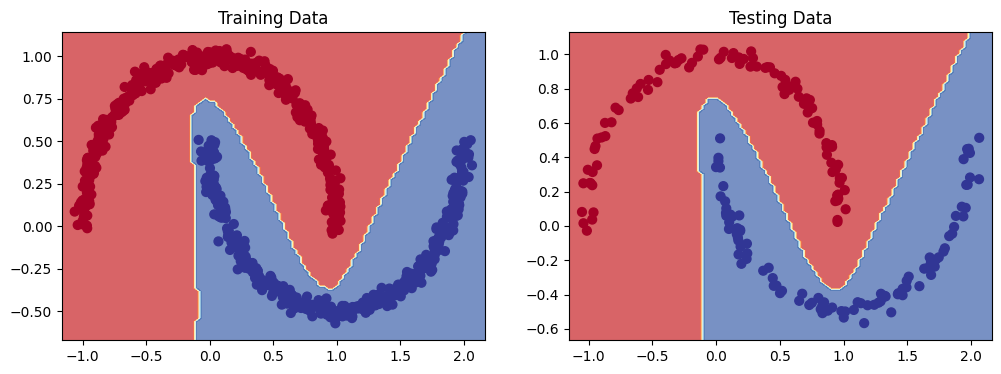

In [ ]:
# plotting the results
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Training Data')
plot_decision_boundary(model1,x_train,y_train)

plt.subplot(1,2,2)
plt.title('Testing Data')
plot_decision_boundary(model1,x_test,y_test)

# day 204

# Goal 7
1. Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).
Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
------
2. Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
----------
3. Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
---------
4. Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

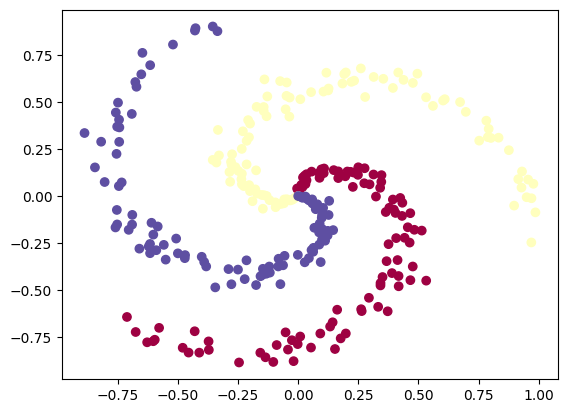

In [ ]:
# 1 creating a spiral dataset
n = 100 # # of dots
dimension = 2
classes = 3

# creating a data matrix:
x = np.zeros((n*classes,dimension)) #(each row = single example)

# creating a class_labels array
y = np.zeros(n*classes,dtype='uint8')

# creating spirals
for j in range(classes):
  ix = range(n*j,n*(j+1))

  # getting radius
  r = np.linspace(0,1,n)

  # getting angles(theta)
  theta = np.linspace(j*4,(j+1)*4,n) + np.random.randn(n)*0.2

  # prepping the data
  x[ix] = np.c_[r*np.sin(theta), r*np.cos(theta)]
  y[ix] = j

# lets visualize the data
plt.scatter(x=x[:,0],y=x[:,1],c=y,cmap=plt.cm.Spectral)
plt.show()


In [ ]:
# data preparation
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

# converting to tensors with dtype torch.float32
def tensor_convert(x):
  return torch.tensor(x,dtype=torch.float32)

x_train,x_test,y_train,y_test = map(tensor_convert,(x_train,x_test,y_train,y_test))

# making the data agnostic to device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def device_agnostic(x):
  return x.to(device)

x_train,x_test,y_train,y_test = map(device_agnostic,(x_train,x_test,y_train,y_test))

In [ ]:
# building a model class:
class ClassificationModelV2(torch.nn.Module):
  def __init__(self,i,o,h):
    super().__init__()

    self.neural_layers_stack = torch.nn.Sequential(
        torch.nn.Linear(in_features=i,out_features=h),
        torch.nn.Tanh(),
        torch.nn.Linear(in_features=h,out_features=h),
        torch.nn.Tanh(),
        torch.nn.Linear(in_features=h,out_features=h),
        torch.nn.Tanh(),
        torch.nn.Linear(in_features=h,out_features=h),
        torch.nn.Tanh(),
        torch.nn.Linear(in_features=h,out_features=o)
    )

  def forward(self,x):
    return self.neural_layers_stack(x)

model2 = ClassificationModelV2(i=x.shape[1],o=len(np.unique(y)),h=5)


In [ ]:
# 2 compiling the model2
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model2.parameters(),
                             lr=0.1)
metrics = torchmetrics.Accuracy(task='multiclass',num_classes=len(np.unique(y)))



In [ ]:
# 3. fitting the model2
torch.random.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100
for epoch in range(epochs):

  # training the model
  model2.train()

  # getting train loss and train accuracy
  train_logits = model2(x_train)
  train_prediction = torch.argmax(torch.softmax(train_logits,dim=1),dim=1)
  train_actual = y_train
  train_loss = loss(train_logits,train_actual.long())
  train_accuracy = metrics(train_prediction,train_actual)

  # zero grad
  optimizer.zero_grad()

  # back propogate
  train_loss.backward()

  # step the optimizer up a notch:
  optimizer.step()

  # testing
  model2.eval()

  with torch.inference_mode():

    # getting test loss and test accuracy
    test_logits = model2(x_test)
    test_prediction = torch.argmax(torch.softmax(test_logits,dim=1),dim=1)
    test_actual = y_test
    test_loss = loss(test_logits,test_actual.long())
    test_accuracy = metrics(test_prediction,test_actual)

    # printing

    if epoch%10 == 0:
      print('Epoch: {} |Train Loss: {:.4f}, Train Accuracy: {:.4f} | Test Loss:{:.4f}, Test Accuracy: {:.4f}'\
            .format(epoch,train_loss,train_accuracy,test_loss,test_accuracy))



Epoch: 0 |Train Loss: 1.1536, Train Accuracy: 0.3250 | Test Loss:1.1064, Test Accuracy: 0.2667
Epoch: 10 |Train Loss: 0.7337, Train Accuracy: 0.6375 | Test Loss:0.8782, Test Accuracy: 0.5167
Epoch: 20 |Train Loss: 0.4471, Train Accuracy: 0.7750 | Test Loss:0.5827, Test Accuracy: 0.6667
Epoch: 30 |Train Loss: 0.3478, Train Accuracy: 0.8417 | Test Loss:0.3743, Test Accuracy: 0.9000
Epoch: 40 |Train Loss: 0.1653, Train Accuracy: 0.9500 | Test Loss:0.1299, Test Accuracy: 0.9833
Epoch: 50 |Train Loss: 0.0851, Train Accuracy: 0.9667 | Test Loss:0.0542, Test Accuracy: 0.9833
Epoch: 60 |Train Loss: 0.0518, Train Accuracy: 0.9792 | Test Loss:0.0201, Test Accuracy: 1.0000
Epoch: 70 |Train Loss: 0.1155, Train Accuracy: 0.9458 | Test Loss:0.0504, Test Accuracy: 0.9833
Epoch: 80 |Train Loss: 0.0772, Train Accuracy: 0.9625 | Test Loss:0.0883, Test Accuracy: 0.9500
Epoch: 90 |Train Loss: 0.0412, Train Accuracy: 0.9917 | Test Loss:0.0210, Test Accuracy: 1.0000


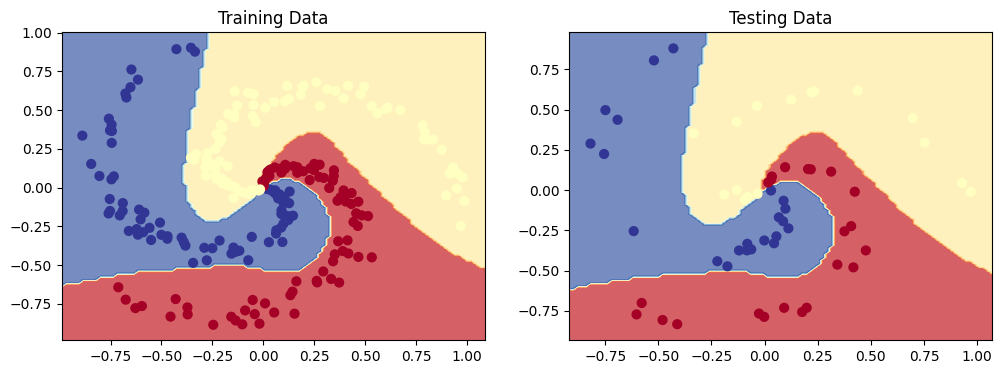

In [ ]:
# visualize
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Training Data')
plot_decision_boundary(model2,x_train,y_train)

plt.subplot(1,2,2)
plt.title('Testing Data')
plot_decision_boundary(model2,x_test,y_test)

plt.show()

# exploration,analysis and freethrows

In [ ]:
x_train

In [ ]:
np.unique(y)

array([0, 1, 2], dtype=uint8)

In [ ]:
x.shape,y.shape

((300, 2), (300,))

In [ ]:
x = np.linspace(0,2*np.pi,100)

[x*np.sin(x) + x*np.cos(x)]

[array([ 0.        ,  0.06736403,  0.1419806 ,  0.22299214,  0.30948729,
         0.40050691,  0.49505041,  0.59208233,  0.69053913,  0.78933621,
         0.88737501,  0.98355032,  1.0767575 ,  1.1658999 ,  1.24989615,
         1.32768738,  1.39824447,  1.46057501,  1.51373016,  1.55681132,
         1.58897646,  1.6094462 ,  1.61750962,  1.61252958,  1.59394778,
         1.5612893 ,  1.51416676,  1.45228392,  1.37543888,  1.28352668,
         1.17654141,  1.05457771,  0.91783179,  0.76660181,  0.60128769,
         0.42239033,  0.23051028,  0.02634581, -0.18930965, -0.41557053,
        -0.65146278, -0.89592808, -1.14782847, -1.40595161, -1.66901641,
        -1.93567922, -2.20454034, -2.47415096, -2.74302052, -3.0096243 ,
        -3.27241135, -3.52981267, -3.78024955, -4.02214217, -4.25391819,
        -4.47402156, -4.68092124, -4.87311999, -5.04916306, -5.2076468 ,
        -5.3472271 , -5.46662765, -5.56464796, -5.64017107, -5.69217099,
        -5.7197197 , -5.72199383, -5.69828079, -5.6

In [ ]:
np.c_[x*np.sin(x), x*np.cos(x)]

array([[ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
         0.00000000e+00],
       [ 5.20075146e-06,  9.68280864e-05,  2.28051067e-03,
         9.83972934e-03],
       [ 8.33713245e-06,  3.99757839e-04,  2.88739927e-03,
         1.99906145e-02],
       ...,
       [ 3.61430188e-01,  5.20843192e-01, -5.05099899e-01,
         5.50425982e-01],
       [ 3.96612726e-01,  5.03952572e-01, -5.18608307e-01,
         5.47426328e-01],
       [ 3.85701625e-01,  5.30719398e-01, -5.14652594e-01,
         5.51999895e-01]])

In [ ]:
np.vstack([x*np.sin(x), x*np.cos(x)])

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 5.20075146e-06,  9.68280864e-05],
       [ 8.33713245e-06,  3.99757839e-04],
       ...,
       [-5.05099899e-01,  5.50425982e-01],
       [-5.18608307e-01,  5.47426328e-01],
       [-5.14652594e-01,  5.51999895e-01]])

In [ ]:
np.c_[x*np.sin(x), x*np.cos(x)].shape

(300, 4)

In [ ]:
np.vstack([x*np.sin(x), x*np.cos(x)]).shape

(600, 2)

In [ ]:
np.reshape([x*np.sin(x), x*np.cos(x)],(300,4))

array([[ 0.00000000e+00,  0.00000000e+00,  5.20075146e-06,
         9.68280864e-05],
       [ 8.33713245e-06,  3.99757839e-04,  4.27556904e-08,
         9.18090372e-04],
       [ 4.30476020e-07,  1.63161211e-03,  4.98692909e-04,
         2.05132403e-03],
       ...,
       [-2.37366444e-01,  5.57671064e-01, -4.66458619e-01,
         5.55938824e-01],
       [-4.86008740e-01,  5.53825960e-01, -5.05099899e-01,
         5.50425982e-01],
       [-5.18608307e-01,  5.47426328e-01, -5.14652594e-01,
         5.51999895e-01]])

# day 204

# EC 1:
Write down 3 problems where you think machine classification could be useful (these can be anything, get creative as you like, for example, classifying credit card transactions as fraud or not fraud based on the purchase amount and purchase location features).

1. for classifying different materials to be segeregated for waste management. we can save human labors the stench, the stigma, frowns from the mob if machines were made to do these types of jobs.
----------
2. for classifying one tissue from the other in an organism's body to perform surgery or any kind of upgrade or modifications to the organism.
------------
3. for classifying cancerous vs non-cancerous cells well before they form a tumor colony in an organism's body.

# EC2:
Research the concept of "momentum" in gradient-based optimizers (like SGD or Adam), what does it mean?

# Momentum:
* it is the accumulation of past gradients that will guide the optimization algorithm to avoid small local minimums and reach the ideal value. The past gradients in this context gives the algo the velocity(the speed and direction based on past records(weights and biases)) to reach the optimal point on the valley.it is the accumulated memory of the past. it is the accumulated gradients, that will guide the algo how far it further has to go down.

* without momentum, the algo would have settled for one of the local minimums for the ideal value.

* A good analogy would be a car rolling downhill, if the hill is steeper then a small bump along the way wouldn't stop the car from reaching the valley (the down-most point). All small local minimums will be avoided based on how steep the road the car traversed a while ago was (which sets the weight and biases learning metrics). it gives the car the natural velocity to avoid small bumps along the way.


# comparing Momentum with learning rate:
* learning rate is the speed of the car. step size in the context of optimization algo.

* momentum is the natural speed of the car due to past speed,friction, steepness of the hill. it is the accumulated memory of the car about the speed, mass, friction, bumps it may have come across, and so on.

* this accumulation of memories of the past is analogous to the mass and the speed at which the algorithm converges to the optimal point is analogous to the velocity. momentum(p) = m.v



# EC3:
Spend 10-minutes reading the Wikipedia page for different activation functions, how many of these can you line up with PyTorch's activation functions?

* sigmoid
* tanh
* relu
* softmax.

# softmax:
$$ \text{softmax } = \frac{e^{x_{i}}}{\sum_{j}^{N} x_{j}} $$
for x = 1,2,3,4 ......N

# sigmoid Linear Unit:
$$ \text{SiLU } = \frac{x}{1+e^{-x}}  $$

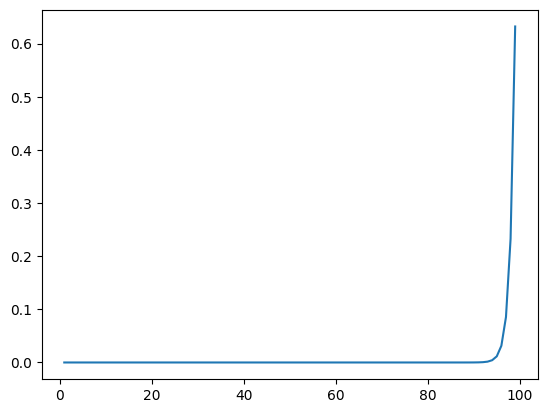

In [ ]:
# softmax:
x = np.arange(1,100,1)
softmax = np.exp(x)/sum(np.exp(x))

# plotting
plt.plot(x,softmax)
plt.show()

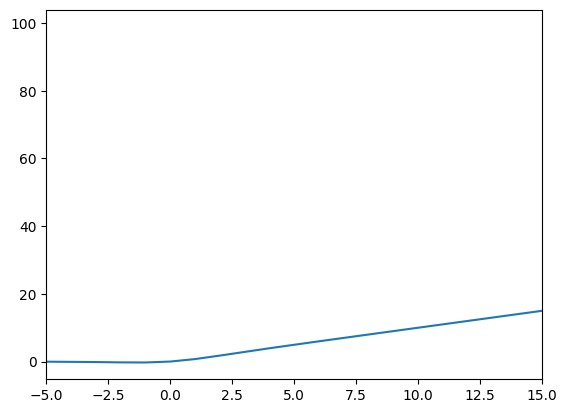

In [ ]:
# Sigmoid Linear Unit:
x = np.arange(-100,100,1)
silu = x/(1+np.exp(-x))

# plotting
plt.plot(x,silu)
plt.xlim([-5,15])
plt.show()

# EC4:
Research when accuracy might be a poor metric to use (hint: read "Beyond Accuracy" by by Will Koehrsen for ideas).

# lessons learned:
* pure accuracy without considering precision and recall might give us a false narrative about the situation.
---------------
* always read the classification report of the model and make sure all accuracy, precision, recall and f1 score are within a reliable threshold of value.
--------------
* for a imbalanced dataset, precision,accuracy,recall, and f1 score are all must to see